In [770]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats.mstats import winsorize

cleaned_data = pd.read_csv("data/cleaned_data.csv", sep=',') 
scraped_data = pd.read_csv("data/immoweb_data.csv", sep=',') 

In [771]:
# Combine dfs and remove duplicates
combined_data = pd.concat([cleaned_data, scraped_data], ignore_index=True)
combined_data = combined_data.drop_duplicates()

In [772]:
combined_data = combined_data.dropna(subset=['Price']) 

In [773]:
combined_data.shape

(34970, 20)

### Data Augmentation (Feature creation)

As the aim of the project is to develop a machine learning model to predict real estate prices, research in this field was conducted.
There are two main categories of factors that can affect the value of a property: property characteristics and locational attributes (or neighborhood characteristics).

* **Property characteristics** are the structural attributes of the property, such as size, year of construction, amenities, type of property, among others.

The dataset __[*cleaned_data*](https://github.com/MaximSchuermans/immo-eliza/blob/main/data/cleaned_data.csv)__ is the result of the scraping process from __[Immoweb](https://www.immoweb.be/)__ and contains mainly property characteristics for 24,342 observations.

* **Neighborhood characteristics** include social demographics, proximity to, and quality of public services, such as schools, hospitals, and public transportation. Proximity to amenities such as grocery stores, restaurants, or commercial centers, as well as factors related to safety and environmental issues, such as crime rates or air quality, also play a role.

Regarding neighborhood characteristics, the dataset cleaned_data only includes the postal code.


#### Add featues: 

1. Region, province, and municipality: To add geo-spatial related data, the dataset is being merged with the __[*postal_codes_belgium*](https://data.gov.be/en/datasets/httpswwwodwbbeexploredatasetpostal-codes-belgium)__ dataframe, another dataset from the Geographical repository maintained by Opendatasoft. This repository contains a list of Belgian postal codes along with the corresponding region, province, and municipality.

2. Prosperity Index: The Prosperity Index is a comparative measure of the average income in a municipality relative to the national average. This value will be added from the __[fisc2022_c_NL](https://statbel.fgov.be/en/themes/households/taxable-income#figures)__ dataset, which contains fiscal statistics from 2022.

3. Total population and 'Population / km²': The __[Pop_density_en](https://statbel.fgov.be/en/themes/population/structure-population/population-density#figures)__ dataset includes total population and population density (Population / km²) by municipality, with data from January 2024.

4. Crime rate: The crime rate will be calculated using data from the Federal Police data portal __[criminal_figures_statistics_table](https://www.politie.be/statistieken/nl/criminaliteit/criminele-figuren/tabel?view=undefined&year=2023)__. The specific database contains criminal figures per year, per municipality. Only data from the year 2023 will be used, up to and including 31 December 2023. The total population mentioned above will be used to calculate the crime rate per 1,000 inhabitants.

No additional neighborhood characteristics will be added due to time constraints and difficulty in finding reliable data.

In [774]:
# Load data used for adding features
postal_codes_belgium = pd.read_csv("data/postal-codes-belgium.csv", sep=';') 
codes_nis = pd.read_csv("data/codes-ins-nis-postaux-belgique.csv", sep=';') 
fiscal_statistics = pd.read_excel("data/fisc2022_C_NL.xls", sheet_name='Totaal', skiprows=5, header=[1])
pop_density = pd.read_excel("data/Pop_density_en.xlsx", sheet_name='2024', skiprows=0, header=[1])
criminal_figures = pd.read_csv("data/criminal_figures_statistics_table.csv", delimiter=";", skiprows=0, header=[1])

In [775]:
# Create new dataframes with only the specified columns from each dataframes
postal_codes = pd.DataFrame({
    'geo_point': postal_codes_belgium['﻿Geo Point'],

    'postal_code': postal_codes_belgium['Postal Code'],

    'region': postal_codes_belgium['Région name (French)'],

    'province': postal_codes_belgium['Province name (French)'].combine_first(
                    postal_codes_belgium['Province name (Dutch)']).combine_first(
                    postal_codes_belgium['Région name (French)']),

    'municipality': postal_codes_belgium['Municipality name (French)'].combine_first(
                        postal_codes_belgium['Municipality name (Dutch)'])
})

nis = pd.DataFrame({
    'nis': codes_nis['NIS-code Municipaity'],

    'postal_code': codes_nis['Postal code'],
})

prosperity_index = pd.DataFrame({
    'nis': fiscal_statistics['Unnamed: 1'],

    'prosperity_index': fiscal_statistics['Unnamed: 18'],
})

population = pd.DataFrame({
    'nis': pop_density['Refnis'],

    'total_population': pop_density['Population'],

    'Population_km': pop_density['Population / km²'],
})

criminal_statistics = pd.DataFrame({
    'municipality': criminal_figures[' '],

    'crimes': criminal_figures['2023'],
})

In [776]:
postal_codes.drop_duplicates(subset=['postal_code'], inplace=True)

* Prepare cleaned_data dataframe to merge

In [777]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34970 entries, 0 to 49852
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Price                      34970 non-null  float64
 1   Locality                   34970 non-null  object 
 2   Type_of_Property           34970 non-null  object 
 3   Subtype_of_Property        34970 non-null  object 
 4   State_of_the_Building      28920 non-null  object 
 5   Number_of_Rooms            34970 non-null  float64
 6   Living_Area                33477 non-null  float64
 7   Fully_Equipped_Kitchen     34970 non-null  int64  
 8   Furnished                  15022 non-null  float64
 9   Open_fire                  1488 non-null   float64
 10  Terrace                    23144 non-null  float64
 11  Terrace_Area               13955 non-null  float64
 12  Garden                     7801 non-null   float64
 13  Garden_Area                7801 non-null   float64


In [778]:
combined_data = combined_data.rename(columns={"Locality" : "postal_code"})

# Convert Postal_Code columns form both df to int
combined_data["postal_code"] = pd.to_numeric(combined_data["postal_code"], errors='coerce').astype('Int64')
postal_codes["postal_code"] = pd.to_numeric(postal_codes["postal_code"], errors='coerce').astype('Int64')

* Merge new features with clean_data 

In [779]:
postal_codes = postal_codes.merge(nis, on=["postal_code"], how='inner', copy=True)

postal_codes = postal_codes.merge(prosperity_index, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(population, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(criminal_statistics, on=['municipality'], how='inner', copy=True)

real_estate_data = combined_data.merge(postal_codes, on=["postal_code"], how='inner', copy=True)

* Calculate crime rate per 1,000 inhabitants 

In [780]:
real_estate_data['crimes'] = pd.to_numeric(real_estate_data['crimes'], errors='coerce')
real_estate_data['total_population'] = pd.to_numeric(real_estate_data['total_population'], errors='coerce')

real_estate_data['crime_rate'] = (real_estate_data['crimes'] / real_estate_data['total_population']) * 1000

* Convert Geo Point into 'latitude' and 'longitude' 

In [781]:
# Convert Geo Point data to float
Geo_Point = real_estate_data['geo_point']
Geo_Point = [Geo_Point[i].split(',') for i in range(0,len(Geo_Point))]

Geo_Point_latitude= [float(Geo_Point[i][0:2][0]) for i in range(0,len(Geo_Point))]
Geo_Point_longitude= [float(Geo_Point[i][0:2][1]) for i in range(0,len(Geo_Point))]

# Add latitude and longitude coordinates
real_estate_data.insert(0,'longitude',Geo_Point_latitude)
real_estate_data.insert(1,'latitude', Geo_Point_longitude)

# Delte Geo Point column
del real_estate_data['geo_point']

* Reorder columns

In [782]:
# Define column order
column_order = [
    "Price", "postal_code", "longitude", "latitude", "region", "province", 
    "municipality", "crime_rate", "total_population", "Population_km", 
    "prosperity_index"
] + [col for col in real_estate_data.columns if col not in [
    "Price", "postal_code", "longitude", "latitude", "region", "province", 
    "municipality", "crime_rate", "total_population", "Population_km", 
    "prosperity_index"
]]

# Reorder the DataFrame columns
real_estate_data = real_estate_data[column_order]

* Convert all column names and all string to lowercase 

In [783]:
real_estate_data.columns = real_estate_data.columns.str.lower()
real_estate_data = real_estate_data.map(lambda x: x.lower() if isinstance(x, str) else x)

* Drop Unnecessary Columns and Duplicates

Some columns were used to derive new features but are not needed for further analysis, as they contain redundant information already represented in other features.

In [784]:
columns_to_drop = ['nis','total_population', 'crimes']
real_estate_data = real_estate_data.drop(columns=columns_to_drop)

real_estate_data.drop_duplicates(inplace=True)

In [785]:
real_estate_data.head(10)

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,terrace,terrace_area,garden,garden_area,surface_of_the_land,surface_area_plot_of_land,number_of_facades,swimming_pool,disabled_access,lift
0,475000.0,1800,50.930129,4.428578,région flamande,brabant flamand (le),vilvoorde,22.742122,2199.232426,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,895000.0,2000,51.248448,4.376134,région flamande,antwerpen,antwerpen,38.339890,2666.254939,87.0,...,1.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,289000.0,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,9.176391,223.812277,98.0,...,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,775000.0,2980,51.263556,4.682858,région flamande,antwerpen,zoersel,13.609966,583.095609,121.0,...,1.0,NaN,NaN,NaN,NaN,3715.0,4.0,0.0,NaN,0.0
4,1495000.0,8670,51.121347,2.700627,région flamande,flandre occidentale (la),koksijde,21.628144,427.834883,137.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
5,259000.0,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.285628,274.633658,110.0,...,NaN,NaN,1.0,200.0,200.0,200.0,NaN,NaN,NaN,NaN
6,230000.0,8690,51.014761,2.721211,région flamande,flandre occidentale (la),alveringem,11.148716,62.236370,96.0,...,NaN,NaN,1.0,1656.0,1656.0,1656.0,3.0,NaN,0.0,0.0
7,1195000.0,8300,51.346652,3.331958,région flamande,flandre occidentale (la),knokke-heist,24.697054,527.878757,150.0,...,1.0,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0
8,429210.0,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,1.0,12.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,1.0
9,314000.0,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,23.406837,1377.249099,103.0,...,1.0,10.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,1.0


***

### Data Cleaning 

#### Missing values

In [786]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                           Missing Count Missing Percentage  Unique Values
price                                  0               0.0%           2468
postal_code                            0               0.0%            922
longitude                              0               0.0%            904
latitude                               0               0.0%            904
region                                 0               0.0%              3
province                               0               0.0%             11
municipality                           0               0.0%            511
crime_rate                             0               0.0%            512
population_km                          0               0.0%            513
prosperity_index                       0               0.0%             72
type_of_property                       0               0.0%              2
subtype_of_property                    0               0.0%             23
state_of_the_building    

* Visualizing missing data

<Axes: >

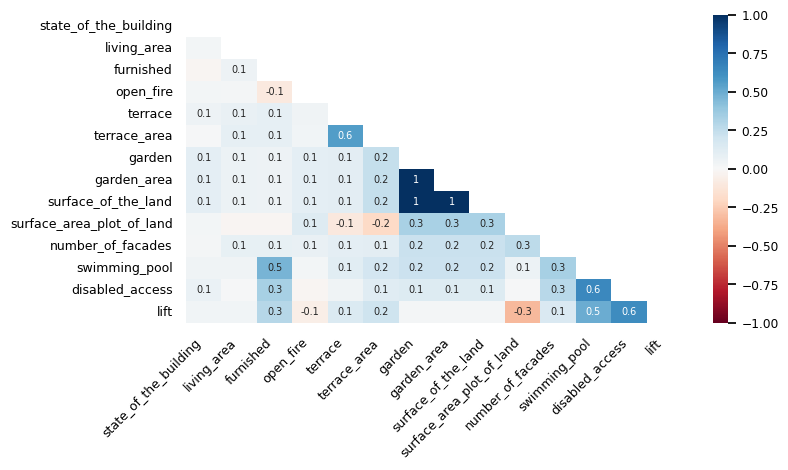

In [787]:
msno.heatmap(real_estate_data, figsize=(8, 4), fontsize=9)

<Axes: >

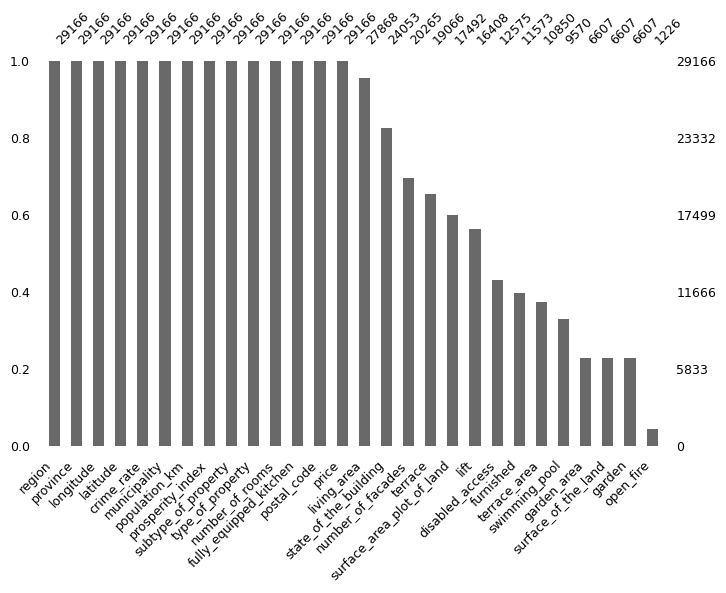

In [788]:
# Visualize the count of non-null values for each column
msno.bar(real_estate_data, figsize=(8, 5), fontsize=9, sort="descending")

<Axes: >

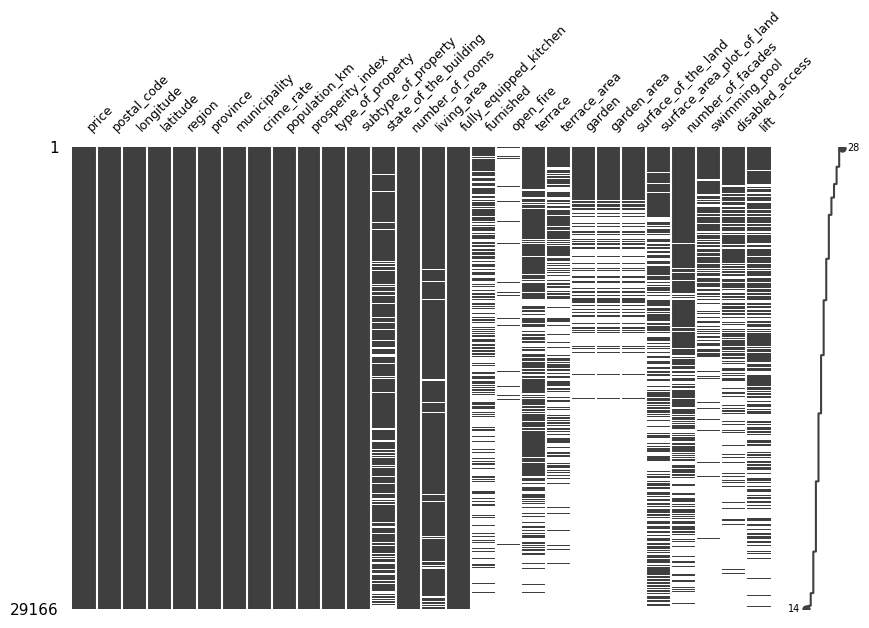

In [789]:
sorted_data = msno.nullity_sort(real_estate_data, sort='descending') # or sort='ascending'
msno.matrix(sorted_data, figsize=(10, 6), fontsize=9)

* Missing values | Categorical variables

The feature 'open_fire' indicates the total number of chimneys each observation has. Since the exact count is not needed, this column will be transformed into a boolean column, representing whether an observation has a chimney or not.

In [790]:
# Fill missing values wirh zero and replace all non-zero with 1
real_estate_data['open_fire'] = real_estate_data['open_fire'].fillna(0)
real_estate_data['open_fire'] = real_estate_data['open_fire'].apply(lambda x: 1 if x != 0 else 0)

The dataframe contains 8 boolean columns, where 1 represents True and 0 represents False, indicating whether an observation has specific features.
For these columns, all missing values will be assumed to represent False, meaning the observation does not have that feature.

The 8 boolean columns are:
* fully_equipped_kitchen
* furnished
* open_fire
* terrace
* garden
* swimming_pool
* disabled_access
* lift

In [791]:
# Fill missing values in boolean columns with 0 = False
boolean_columns = ['furnished',
                'open_fire',
                'terrace',
                'garden',
                'swimming_pool',
                'disabled_access', 
                'lift']

real_estate_data[boolean_columns] = real_estate_data[boolean_columns].fillna(0)

The 'state of the building' column contains categorical variables. The missing values in this column are MCAR: Missing Completely At Random and account for 15.756% of the total observations. Mode imputation will be applied, as it is the most appropriate method for categorical variables. Before imputation, the data will be grouped by 'type_of_property' and 'municipality.' Observations that do not have a matching group will be imputed using the global mode.

In [792]:
# Calculate the mode for each group (type_of_property, municipality)
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['state_of_the_building'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'state_of_the_building' with the mode of the corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['state_of_the_building']):
        group_mode = mode_values.get((row['type_of_property'], row['municipality']))
        return group_mode
    return row['state_of_the_building']

# Apply the function to the 'state_of_the_building' column
real_estate_data['state_of_the_building'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with the global mode
real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].fillna(real_estate_data['state_of_the_building'].mode()[0])

* Missing values | Numerical variables

In [793]:
# 'surface_of_the_land' | Check if two columns are the same
are_columns_equal = real_estate_data['surface_of_the_land'].equals(real_estate_data['garden_area'])
if are_columns_equal:
    print("The 'surface_of_the_land' and 'garden_area' columns contain identical data.")
else:
    print("The 'surface_of_the_land' and 'garden_area' columns have different values.")

The 'surface_of_the_land' and 'garden_area' columns contain identical data.


The column 'surface_of_the_land' will be dropped as it contains the same data as the column 'garden_area'.

In [794]:
# delete Surface_of_the_Land column
del real_estate_data['surface_of_the_land']

In [795]:
# Missing values for houses with a garden
missing_houses_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 0) & 
                                            (real_estate_data['garden'] == 1) & 
                                            (real_estate_data['garden_area'].isna())].shape[0]

# Missing values for apartments with a garden
missing_apartments_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 1) & 
                                                (real_estate_data['garden'] == 1) & 
                                                (real_estate_data['garden_area'].isna())].shape[0]

print(f"Missing values in garden area for houses with gardens: {missing_houses_with_garden}")
print(f"Missing values in garden area for apartments with gardens: {missing_apartments_with_garden}")

Missing values in garden area for houses with gardens: 0
Missing values in garden area for apartments with gardens: 0


All missing values in 'terrace_area' and 'garden_area' belong to observations that don't have a terrace or garden. Since the feature doesn't exist, the missing values are being filled with area = 0

In [796]:
real_estate_data['garden_area'] = real_estate_data['garden_area'].fillna(0)
real_estate_data['terrace_area'] = real_estate_data['terrace_area'].fillna(0)

The columns 'garden_area' and 'terrace_area' represent both exterior spaces. 

In [797]:
# Create new column 'ext_area' as the sum of 'garden_area' and 'terrace_area'
real_estate_data['ext_area'] = real_estate_data['garden_area'] + real_estate_data['terrace_area']

# Drop the 'garden_area' and 'terrace_area' columns
real_estate_data.drop(['garden_area', 'terrace_area'], axis=1, inplace=True)

In [798]:
# Create a new column 'exterior_space' by combining 'garden' and 'terrace'
real_estate_data['garden'] = real_estate_data['garden'].astype(int)
real_estate_data['terrace'] = real_estate_data['terrace'].astype(int)

real_estate_data['exterior_space'] = (real_estate_data['garden'] | real_estate_data['terrace']).astype(int)

# Drop the 'garden' and 'terrace' columns
real_estate_data.drop(['garden', 'terrace'], axis=1, inplace=True)

In [799]:
# Create a new column by combining 'disabled_access' and 'lift'
real_estate_data['disabled_access'] = real_estate_data['disabled_access'].astype(int)
real_estate_data['lift'] = real_estate_data['lift'].astype(int)

real_estate_data['accessible'] = (real_estate_data['disabled_access'] | real_estate_data['lift']).astype(int)

# Drop the 'garden' and 'terrace' columns
real_estate_data.drop(['lift', 'disabled_access'], axis=1, inplace=True)

In [800]:
# Calculate the percentage of apartments with 0 as 'exterior_space'
percentage_zero_exterior_space = (real_estate_data['exterior_space'] == 0).mean() * 100

print(f"Percentage of apartments with 0 as 'exterior_space': {percentage_zero_exterior_space:.2f}%")

Percentage of apartments with 0 as 'exterior_space': 28.85%


In [801]:
del real_estate_data['ext_area'] 

The column 'living_area' contains a continuous variable and has only 3.639% of missing values.

Median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [802]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['type_of_property', 'municipality'])['living_area'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['living_area']):
        return median_values.loc[(row['type_of_property'], row['municipality'])]
    return row['living_area']

# Apply the function to the 'living_area' column
real_estate_data['living_area'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['living_area'] = real_estate_data['living_area'].fillna(real_estate_data['living_area'].median())

In [803]:
real_estate_data['living_area'].describe()

count    29166.000000
mean       166.951862
std        127.527094
min         12.000000
25%         94.000000
50%        140.000000
75%        198.000000
max       4829.000000
Name: living_area, dtype: float64

The 'number_of_facades' column contains discrete numerical variables. The missing values in this column are MCAR: Missing Completely At Random, and account for  29.915% of the total observations. 

Mode imputation will be used, as it is the most appropriate method when data is discrete. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [804]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_facades' for each group
median_values_facades = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_facades'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'number_of_facades' with the median of corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['number_of_facades']):
        return median_values_facades.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_facades']

# Apply the function to the 'number_of_facades' column
real_estate_data['number_of_facades'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with global median
real_estate_data['number_of_facades'] = real_estate_data['number_of_facades'].fillna(real_estate_data['number_of_facades'].mode()[0])

Zero is not a valid value for the feature 'surface_area_plot_of_land'. All zeros are being converted to NaN in order to facilitate imputation in the next steps.

In [805]:
# Fill 'Surface_area_plot_of_land' zeros with np.nan 
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].replace(0, np.nan)

In [806]:
# Count the number of apartments and houses with non-missing 'surface_area_plot_of_land'
apartment_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 'apartment') & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]
house_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 'house') & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]

print(f"Number of apartments with surface area: {apartment_with_surface}")
print(f"Number of houses with surface area: {house_with_surface}")

# Calculate the percentage of missing surface area for apartments and houses
apartment_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 'apartment') & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]
house_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 'house') & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]

total_apartments = real_estate_data[real_estate_data['type_of_property'] == 'apartment'].shape[0]
total_houses = real_estate_data[real_estate_data['type_of_property'] == 'house'].shape[0]

apartment_missing_percentage = (apartment_missing_surface / total_apartments) * 100 if total_apartments > 0 else 0
house_missing_percentage = (house_missing_surface / total_houses) * 100 if total_houses > 0 else 0

print(f"Percentage of apartments without surface area: {apartment_missing_percentage:.2f}%")
print(f"Percentage of houses without surface area: {house_missing_percentage:.2f}%")

Number of apartments with surface area: 0
Number of houses with surface area: 16347
Percentage of apartments without surface area: 100.00%
Percentage of houses without surface area: 6.55%


In the column 'surface_area_plot_of_land' the missing values are related to the type of property. The percentage of missing values in houses is 5.62%, while the percentage of missing values in apartments is 100%.

Houses come with plots of land because they are standalone properties with space for construction and outdoor features, while apartments are part of a larger building and generally do not include separate land.

In this case, it will be assumed that all missing 'surface_area_plot_of_land' values in apartments are equal to their living area

In [807]:
real_estate_data.loc[real_estate_data['surface_area_plot_of_land'].isna() & (real_estate_data['type_of_property'] == 'apartment'), 'surface_area_plot_of_land'] = real_estate_data['living_area']

For the 5.62% of missing values in houses median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'number of facades' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [808]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['number_of_facades', 'municipality'])['surface_area_plot_of_land'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['surface_area_plot_of_land']):
        return median_values.loc[(row['number_of_facades'], row['municipality'])]
    return row['surface_area_plot_of_land']

# Apply the function to the 'living_area' column
real_estate_data['surface_area_plot_of_land'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].fillna(real_estate_data['surface_area_plot_of_land'].median())

In [809]:
# Calculate the percentage of observations that are apartments
apartment_count = real_estate_data[real_estate_data['type_of_property'] == 'apartment'].shape[0]
total_count = real_estate_data.shape[0]
apartment_percentage = (apartment_count / total_count) * 100
print(f"Percentage of apartments: {apartment_percentage:.2f}%")

Percentage of apartments: 40.03%


Surface_area_plot_of_land repeats information from another feature for apartments, which represent 42% of the dataset. There are two other features related to property size: living_area and exterior_area, which represent the garden and terrace space.

In [810]:
del real_estate_data['surface_area_plot_of_land']

In [811]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                        Missing Count Missing Percentage  Unique Values
price                               0               0.0%           2468
postal_code                         0               0.0%            922
longitude                           0               0.0%            904
latitude                            0               0.0%            904
region                              0               0.0%              3
province                            0               0.0%             11
municipality                        0               0.0%            511
crime_rate                          0               0.0%            512
population_km                       0               0.0%            513
prosperity_index                    0               0.0%             72
type_of_property                    0               0.0%              2
subtype_of_property                 0               0.0%             23
state_of_the_building               0               0.0%        

***

To simplify analysis, broader categories will be created for the column 'state_of_the_building' by combining similar values.

In [812]:
# Define new categories
state_mapping = {
    'just_renovated': 3,
    'as_new': 3,
    'good': 2,
    'to_renovate': 1,
    'to_be_done_up': 1,
    'to_restore': 1
}

real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].map(state_mapping)

# Unique values in 'state_of_the_building'
print(real_estate_data['state_of_the_building'].value_counts())

state_of_the_building
2    15611
3     8201
1     5354
Name: count, dtype: int64


* Define columns per type of data

In [813]:
# Binary columns
binary_columns = [
    col for col in real_estate_data.select_dtypes(include=['int64', 'float64']).columns 
    if real_estate_data[col].nunique() == 2
]

# Discrete Columns
discrete_columns = ['number_of_rooms', 'number_of_facades']

# Continuous columns
continuous_columns = [
    col for col in real_estate_data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in discrete_columns 
    and col not in binary_columns
    and col not in ['postal_code']  
]

# Categorical columns
categorical_columns = (
    real_estate_data.select_dtypes(include=['object', 'category']).columns.tolist()
    + binary_columns
    + ['postal_code']  
)

print("Discrete columns:", discrete_columns)
print("Continuous columns:", continuous_columns)
print("Categorical columns:", categorical_columns)

Discrete columns: ['number_of_rooms', 'number_of_facades']
Continuous columns: ['price', 'longitude', 'latitude', 'crime_rate', 'population_km', 'prosperity_index', 'state_of_the_building', 'living_area']
Categorical columns: ['region', 'province', 'municipality', 'type_of_property', 'subtype_of_property', 'fully_equipped_kitchen', 'furnished', 'open_fire', 'swimming_pool', 'exterior_space', 'accessible', 'postal_code']


***

#### Validation of categorical features

In [814]:
# Unique values in 'region'
real_estate_data['region'].value_counts()

region
région flamande                 21226
région wallonne                  7198
région de bruxelles-capitale      742
Name: count, dtype: int64

In [815]:
# Unique values in 'province'
real_estate_data['province'].value_counts()

province
flandre occidentale (la)        6449
antwerpen                       6012
flandre orientale (la)          5239
liège                           2787
brabant flamand (le)            2721
hainaut (le)                    1618
brabant wallon (le)             1001
luxembourg                       900
namur                            892
limbourg (le)                    805
région de bruxelles-capitale     742
Name: count, dtype: int64

In [816]:
# Unique values in 'municipality'
real_estate_data['municipality'].value_counts()

municipality
antwerpen            2338
knokke-heist         1301
gent                 1297
liège                 667
oostende              633
                     ... 
zuienkerke              2
donceel                 1
as                      1
merbes-le-château       1
baarle-hertog           1
Name: count, Length: 511, dtype: int64

The categorical column 'municipality' has high cardinality (509 unique values). This feature was used to create new features ('crime_rate', 'population_km', and 'prosperity_index') that contain the most important information related to specific locations. These feature will be delete. 

In [817]:
# Unique values in 'type_of_property'
real_estate_data['type_of_property'].value_counts()

type_of_property
house        17492
apartment    11674
Name: count, dtype: int64

In [818]:
# Unique values in 'Subtype_of_Property'
real_estate_data['subtype_of_property'].value_counts()

subtype_of_property
house                   13382
apartment                9343
villa                    1597
apartment_block           650
mixed_use_building        628
ground_floor              610
duplex                    590
penthouse                 389
flat_studio               383
exceptional_property      267
mansion                   236
town_house                225
bungalow                  184
service_flat              164
country_cottage           158
loft                       89
farmhouse                  73
kot                        62
triplex                    44
chalet                     42
manor_house                24
castle                     15
other_property             11
Name: count, dtype: int64

In [819]:
# Label all 'other_property' as the corresponding 'type_of_property'
real_estate_data.loc[real_estate_data['subtype_of_property'] == 'other_property', 'subtype_of_property'] = real_estate_data['type_of_property']

# Group by the 'subtype' column and count the occurrences of each 'property_type' within each 'subtype'
real_estate_data.groupby('subtype_of_property')['type_of_property'].value_counts().unstack(fill_value=0)

# Calculates the percentage of properties where the 'subtype_of_property' column 
# repeats information already present in the 'type_of_property' column ('house' or 'apartment'), 
# and the percentage of properties with a new value that adds unique information. 

total_properties = len(real_estate_data)
subtype_counts = real_estate_data['subtype_of_property'].value_counts()
percentage_by_subtype = (subtype_counts / total_properties) * 100

house_apartment_percentage = percentage_by_subtype[['house', 'apartment']].sum()
other_subtypes_percentage = 100 - house_apartment_percentage

print(f"Percentage of properties in 'house' and 'apartment' subtypes: {house_apartment_percentage:.2f}%")
print(f"Percentage of properties in other subtypes: {other_subtypes_percentage:.2f}%")

Percentage of properties in 'house' and 'apartment' subtypes: 77.95%
Percentage of properties in other subtypes: 22.05%


Only 23% of the observations have a new value in the 'subtype_of_property' column, while 77.36% repeat information that is already present in the 'type_of_property' column.

In [820]:
del real_estate_data['subtype_of_property']

In [821]:
# Unique values in 'state_of_the_building'
real_estate_data['state_of_the_building'].value_counts()

state_of_the_building
2    15611
3     8201
1     5354
Name: count, dtype: int64

####  Outliers

* Visualizing outliers in numerical variables

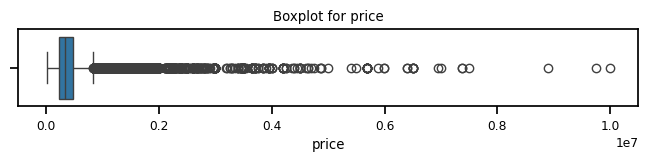

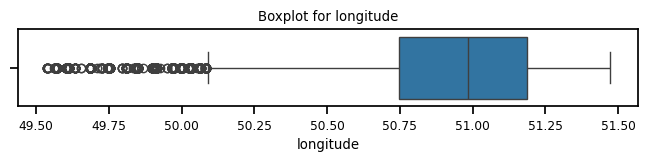

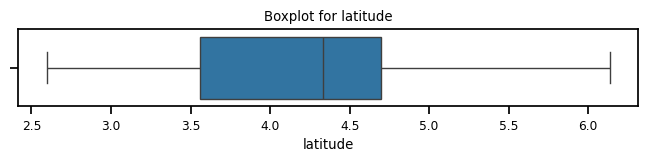

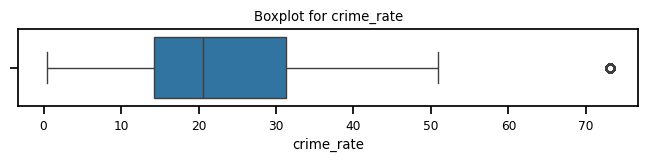

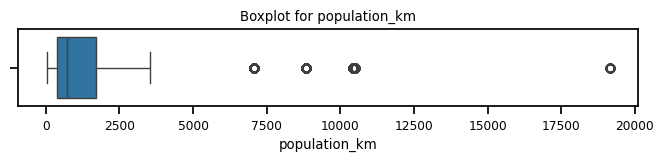

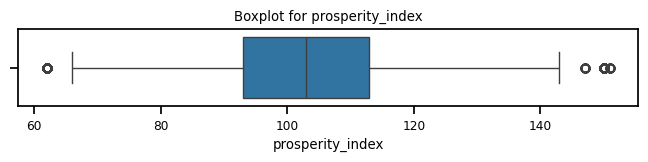

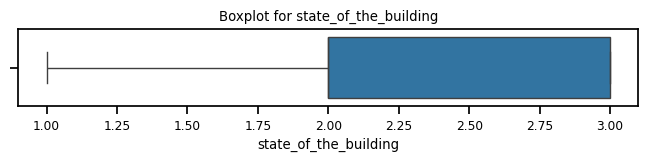

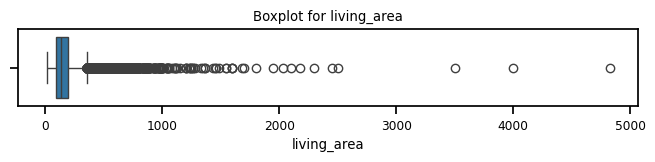

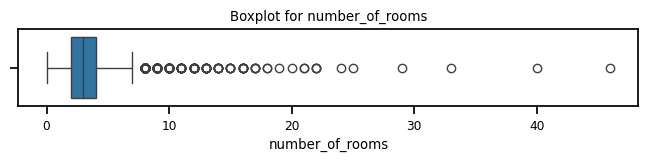

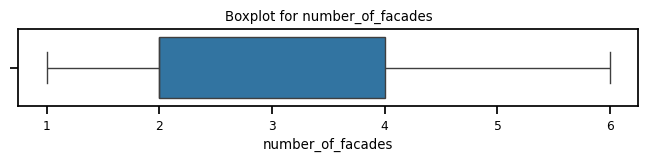

In [822]:
# Plot outlier in continuous and discrete columns   
numerical_columns = continuous_columns + discrete_columns
for column in numerical_columns:
   plt.figure(figsize=(8, 1))
   sns.boxplot(x=real_estate_data[column])
   plt.title(f'Boxplot for {column}')
   plt.show()

In [823]:
# Describe numerical columns
describe_numerical_columns = pd.DataFrame()
for col in numerical_columns:
    description = real_estate_data[col].describe().to_frame().T 
    description['skewness'] = real_estate_data[col].skew()
    description['kurtosis'] = real_estate_data[col].kurt()
    describe_numerical_columns = pd.concat([describe_numerical_columns, description], axis=0) 

describe_numerical_columns

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
price,29166.0,433737.223959,433625.492068,5000.000000,235000.000000,329000.000000,475000.000000,9.999000e+06,6.414082,70.191322
longitude,29166.0,50.922440,0.333036,49.535082,50.746988,50.985271,51.186561,5.147294e+01,-1.251952,2.162813
latitude,29166.0,4.224103,0.807125,2.594588,3.562332,4.335566,4.695740,6.137609e+00,0.082018,-0.763523
crime_rate,29166.0,23.996190,13.235570,0.374478,14.276380,20.564210,31.262495,7.312875e+01,1.360948,2.461891
population_km,29166.0,1207.305669,1624.505015,24.357649,386.748563,735.687301,1708.806368,1.916196e+04,5.107666,38.987019
prosperity_index,29166.0,104.094356,17.041676,62.000000,93.000000,103.000000,113.000000,1.510000e+02,0.576240,0.997416
state_of_the_building,29166.0,2.097614,0.674715,1.000000,2.000000,2.000000,3.000000,3.000000e+00,-0.119251,-0.814256
living_area,29166.0,166.951862,127.527094,12.000000,94.000000,140.000000,198.000000,4.829000e+03,6.844749,136.424169
number_of_rooms,29166.0,2.905506,1.530372,0.000000,2.000000,3.000000,4.000000,4.600000e+01,3.682918,55.589095
number_of_facades,29166.0,2.716862,0.858032,1.000000,2.000000,2.000000,4.000000,6.000000e+00,0.557179,-1.328683


All the numerical columns has positive skew (right-skewed).  

The columns 'living_area' and 'ext_area' have high kurtosis (leptokurtic); the distribution of these columns has more extreme outliers.    
The feature 'ext_area' has the highest skew, 23.17. This column has 27.78% of observations with 0.

To deal with outliers, two methods will be applied:

Trimming outliers: The most extreme values will be discarded.

In [824]:
# Shape of the df before deleting outliers
real_estate_data.shape

(29166, 21)

In [825]:
def detect_and_remove_outliers_iqr(column):
    """
    This function detects and removes outliers from a given numerical column using the IQR (Interquartile Range) method.
    
    Parameters: A numerical column or list to check for outliers.
    
    Returns: A cleaned version of the original column with outliers removed.
    
    Prints:
    - The outliers and their frequency in the original column.
    - The total number of outliers detected.
    """
    # Calculate IQR and bounds
    column_sorted = sorted(column)
    q1 = np.percentile(column_sorted, 25)
    q3 = np.percentile(column_sorted, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (2 * IQR)
    upr_bound = q3 + (1 * IQR)
    
    # Detect outliers
    outliers = [i for i in column_sorted if i < lwr_bound or i > upr_bound]
    
    # Filter out outliers from original data
    column_cleaned = column[(column >= lwr_bound) & (column <= upr_bound)]
    
    # Print info about outliers
    print(f"Outliers:\n{pd.Series(outliers).value_counts().sort_index()}.")
    print(f"Total sum of outliers: {len(outliers)}")
    
    return column_cleaned

In [826]:
# Remove outliers from 'price' column
no_outliers_price = detect_and_remove_outliers_iqr(real_estate_data['price'])
real_estate_data = real_estate_data[real_estate_data['price'].isin(no_outliers_price)]

Outliers:
715863.0      1
717242.0      1
719000.0      5
719600.0      1
720000.0     15
             ..
7365000.0     2
7500000.0     1
8900000.0     1
9750000.0     1
9999000.0     1
Name: count, Length: 475, dtype: int64.
Total sum of outliers: 3094


In [827]:
# Remove outliers from 'living_area' column
no_outliers_living_area = detect_and_remove_outliers_iqr(real_estate_data['living_area'])
real_estate_data = real_estate_data[real_estate_data['living_area'].isin(no_outliers_living_area)]

Outliers:
276.0     14
277.0     21
278.0     18
279.0     14
280.0     62
          ..
1600.0     2
2034.0     1
2175.0     1
3502.0     1
4829.0     1
Name: count, Length: 316, dtype: int64.
Total sum of outliers: 1653


Usually only studios are know for having no separete room. All houses with 0 rooms will be change for the mode in the specific municipality

In [828]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_rooms'
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_rooms'].agg(lambda x: x.mode()[0])

# Function to replace 0s with the mode based on group, for houses only
def replace_with_mode(row):
    if row['number_of_rooms'] == 0 and row['type_of_property'] == 'house':
        return mode_values.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_rooms']

# Apply the function to the 'number_of_rooms' column
real_estate_data['number_of_rooms'] = real_estate_data.apply(replace_with_mode, axis=1)

In [829]:
real_estate_data['number_of_rooms'].value_counts()

number_of_rooms
3.0     8690
2.0     8110
4.0     3478
1.0     2664
5.0      833
0.0      378
6.0      205
7.0       36
8.0       16
10.0       3
9.0        3
12.0       2
16.0       1
Name: count, dtype: int64

In [830]:
# Remove rows where 'number_of_rooms' is less than 10
real_estate_data = real_estate_data[real_estate_data['number_of_rooms'] < 7]

In [831]:
# Remove outliers from 'number_of_facades' column
no_outliers_number_of_facades = detect_and_remove_outliers_iqr(real_estate_data['number_of_facades'])
real_estate_data = real_estate_data[real_estate_data['number_of_facades'].isin(no_outliers_number_of_facades)]

Outliers:
5.0    6
6.0    2
Name: count, dtype: int64.
Total sum of outliers: 8


In [832]:
real_estate_data.shape

(24350, 21)

In [833]:
# Describe numerical columns
describe_numerical_columns = pd.DataFrame()
for col in numerical_columns:
    description = real_estate_data[col].describe().to_frame().T 
    description['skewness'] = real_estate_data[col].skew()
    description['kurtosis'] = real_estate_data[col].kurt()
    describe_numerical_columns = pd.concat([describe_numerical_columns, description], axis=0) 

describe_numerical_columns

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
price,24350.0,318902.660370,133300.949838,5000.000000,220000.000000,299000.000000,396000.000000,715000.000000,0.669016,0.061586
longitude,24350.0,50.909962,0.328758,49.535082,50.724777,50.965217,51.171156,51.472944,-1.254282,2.163988
latitude,24350.0,4.241652,0.808212,2.594588,3.677040,4.349449,4.729643,6.137609,0.036546,-0.742161
crime_rate,24350.0,24.429291,13.535898,0.374478,14.486265,20.625373,31.663173,73.128748,1.322438,2.238920
population_km,24350.0,1272.146159,1707.604744,24.357649,387.133479,773.318326,1708.806368,19161.960361,4.930150,35.789218
prosperity_index,24350.0,102.098932,15.282444,62.000000,92.000000,103.000000,110.000000,151.000000,0.298942,1.062016
state_of_the_building,24350.0,2.073347,0.669716,1.000000,2.000000,2.000000,3.000000,3.000000,-0.085689,-0.778097
living_area,24350.0,133.301006,54.746910,12.000000,90.000000,127.000000,172.000000,275.000000,0.392660,-0.551973
number_of_rooms,24350.0,2.638193,1.065294,0.000000,2.000000,3.000000,3.000000,6.000000,0.244549,0.286823
number_of_facades,24350.0,2.636304,0.819971,1.000000,2.000000,2.000000,3.000000,4.000000,0.719358,-1.068052


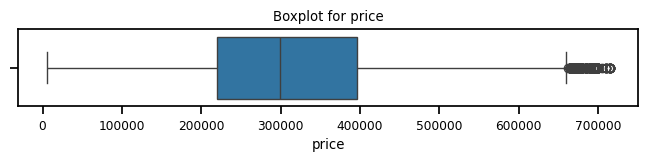

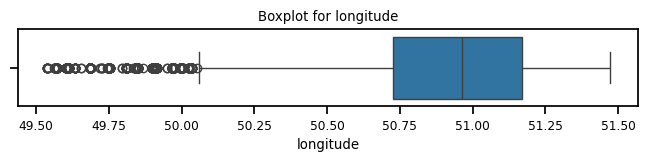

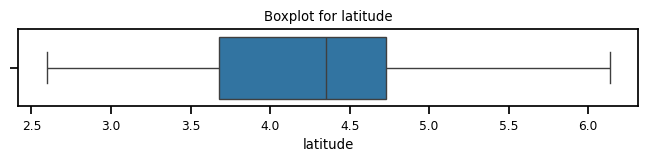

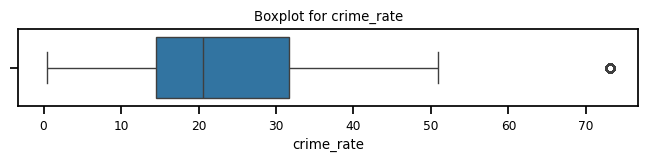

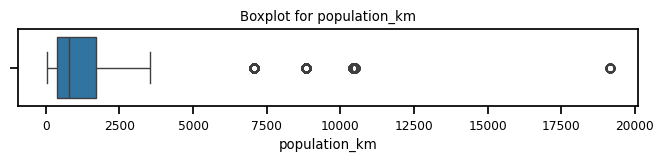

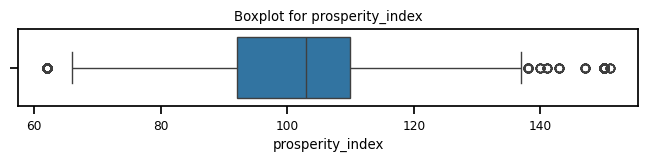

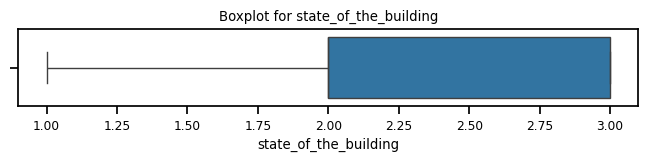

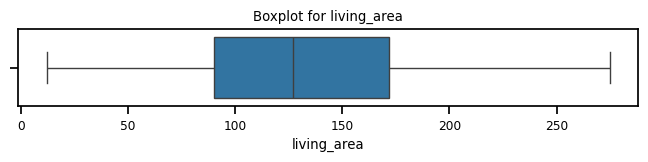

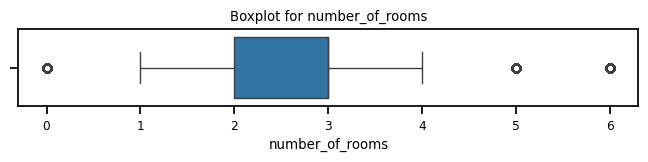

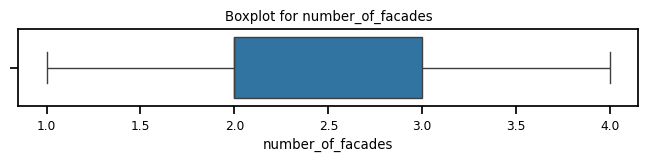

In [834]:
# Plot outlier in continuous and discrete columns   
numerical_columns = continuous_columns + discrete_columns
for column in numerical_columns:
   plt.figure(figsize=(8, 1))
   sns.boxplot(x=real_estate_data[column])
   plt.title(f'Boxplot for {column}')
   plt.show()

In [835]:
# Bins for 'crime_rate'
min_value = real_estate_data['crime_rate'].min()  
max_value = real_estate_data['crime_rate'].max() 

bins = np.linspace(min_value, max_value, 20)  
real_estate_data['crime_rate_bin'] = pd.cut(real_estate_data['crime_rate'], bins=bins, include_lowest=True)

# Mean for each bin
bin_means = real_estate_data.groupby('crime_rate_bin')['crime_rate'].mean()
real_estate_data['crime_rate'] = real_estate_data['crime_rate_bin'].map(bin_means)

real_estate_data.drop(columns=['crime_rate_bin'], inplace=True)

/var/folders/z5/7_mgx29x0z3dnrv56qxnrph00000gn/T/ipykernel_66418/1729786759.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = real_estate_data.groupby('crime_rate_bin')['crime_rate'].mean()


In [836]:
real_estate_data

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,exterior_space,accessible
2,289000.0,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,10.055527,223.812277,98.0,...,3,3.0,120.0,0,0.0,0,1.0,0.0,1,1
5,259000.0,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.729898,274.633658,110.0,...,2,3.0,154.0,0,0.0,0,4.0,0.0,1,0
8,429210.0,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,2,2.0,100.0,1,0.0,0,3.0,0.0,1,1
9,314000.0,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,25.270628,1377.249099,103.0,...,3,2.0,96.0,1,0.0,0,4.0,0.0,1,1
10,229000.0,2500,51.131602,4.561792,région flamande,antwerpen,lier,21.221750,766.455003,109.0,...,2,2.0,105.0,0,0.0,0,2.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29160,179000.0,2861,51.059134,4.575467,région flamande,antwerpen,sint-katelijne-waver,13.889408,602.732409,116.0,...,3,1.0,56.0,1,0.0,0,3.0,0.0,1,1
29161,249000.0,6900,50.212491,5.366233,région wallonne,luxembourg,marche-en-famenne,25.270628,147.224385,94.0,...,2,3.0,129.0,0,0.0,0,3.0,0.0,0,0
29162,579500.0,3130,50.995022,4.785669,région flamande,brabant flamand (le),begijnendijk,10.055527,601.241474,117.0,...,2,4.0,213.0,1,0.0,0,3.0,0.0,0,0
29163,429000.0,8450,51.236712,2.977378,région flamande,flandre occidentale (la),bredene,25.270628,1275.613931,106.0,...,3,3.0,201.0,0,0.0,0,2.0,0.0,1,0


### Exploratory data analysis (EDA)

* Discrete columns

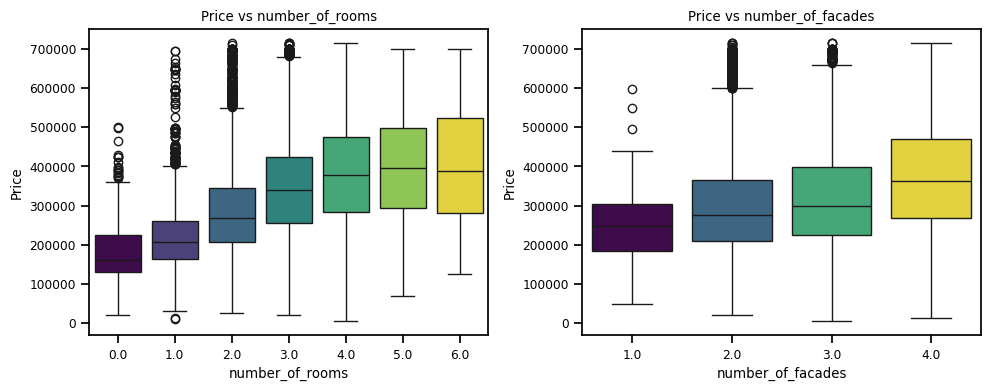

In [837]:
# Plot discrete_columns
fig, axes = plt.subplots(1, len(discrete_columns), figsize=(10, 4))

for i, col in enumerate(discrete_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

In [838]:
# Group by 'type_of_property' and calculate the mean for 'number_of_rooms' and 'number_of_facades'
rooms_per_property_type = real_estate_data.groupby('type_of_property')['number_of_rooms'].mean()
facades_per_property_type = real_estate_data.groupby('type_of_property')['number_of_facades'].mean()

print("Average number of rooms per type of property:")
print(rooms_per_property_type)
print("Average number of facades per type of property:")
print(facades_per_property_type)

Average number of rooms per type of property:
type_of_property
apartment    1.922940
house        3.197001
Name: number_of_rooms, dtype: float64
Average number of facades per type of property:
type_of_property
apartment    2.262547
house        2.928310
Name: number_of_facades, dtype: float64


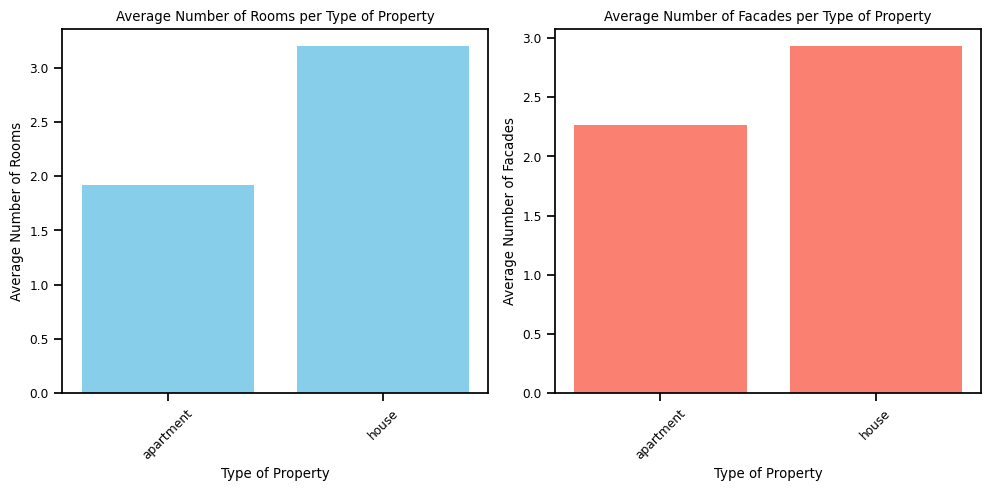

In [839]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the average number of rooms per type of property on the first subplot
axes[0].bar(rooms_per_property_type.index, rooms_per_property_type, color='skyblue')
axes[0].set_title('Average Number of Rooms per Type of Property')
axes[0].set_xlabel('Type of Property')
axes[0].set_ylabel('Average Number of Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the average number of facades per type of property on the second subplot
axes[1].bar(facades_per_property_type.index, facades_per_property_type, color='salmon')
axes[1].set_title('Average Number of Facades per Type of Property')
axes[1].set_xlabel('Type of Property')
axes[1].set_ylabel('Average Number of Facades')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

The number of rooms and number of facades provide information about the type of property. The column 'type_of_property' is redundant and will be deleted.

* Binary columns

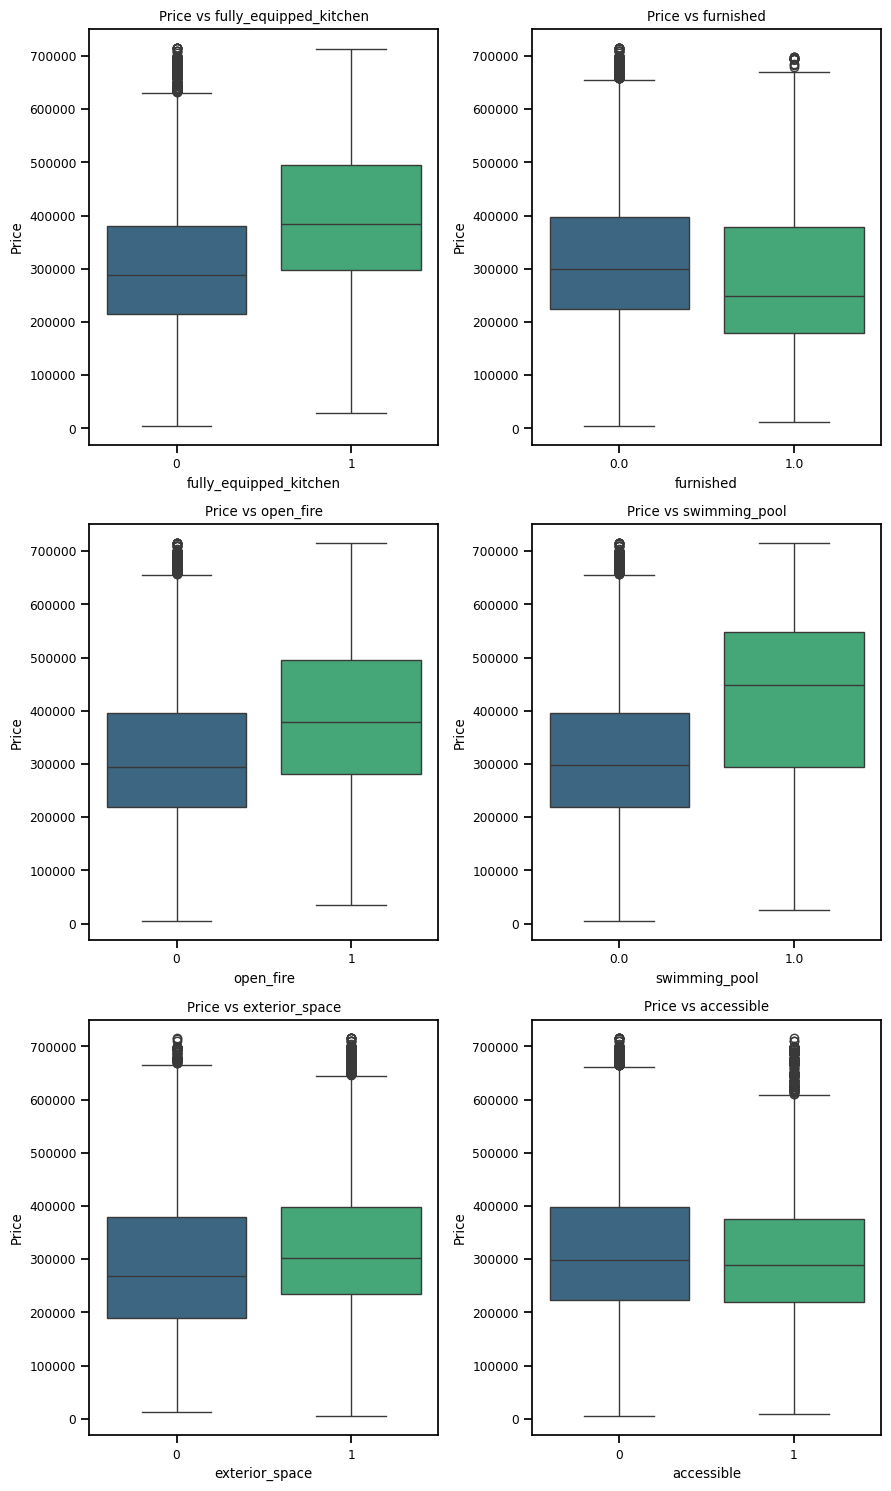

In [840]:
# Plot Binary columns
n_columns = len(binary_columns)
n_rows = (n_columns + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(9, n_rows * 5))

axes = axes.flatten()

for i, col in enumerate(binary_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=0.4, hspace=0.5)  
plt.tight_layout()  
plt.show()

The columns'disable_access' and 'lift' show the difference in price between properties that have the feature and those that do not.
The column 'ext_space' give the similr information as the 'ext_area" column. 


In [841]:
#real_estate_data = real_estate_data.drop(columns=['accesible'])

* Categorical columns

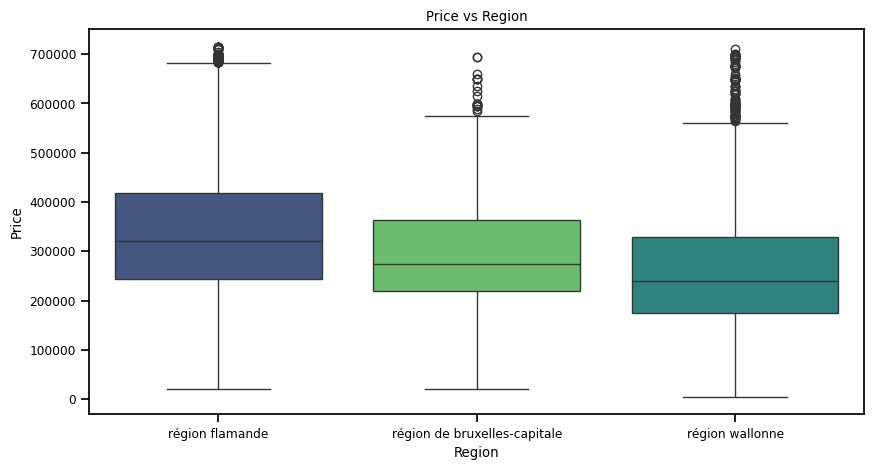

In [842]:
# Plot region sorted using median
median_prices_region = real_estate_data.groupby('region')['price'].median().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.boxplot(data=real_estate_data, x='region', y='price', hue='region', palette='viridis', 
            legend=False, order=median_prices_region.index)

plt.title('Price vs Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.show()

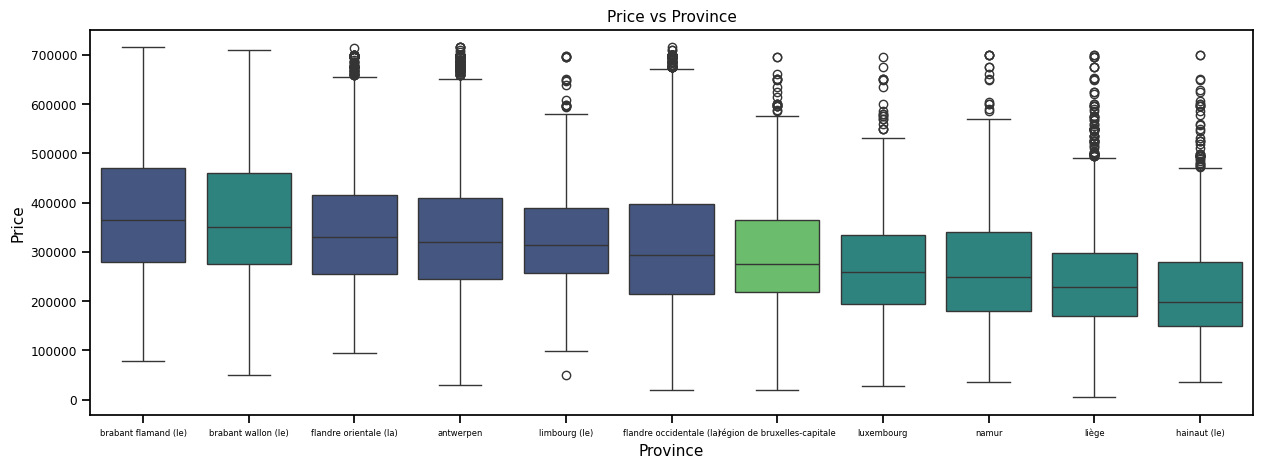

In [843]:
# Plot province sorted using median
median_prices_province = real_estate_data.groupby('province')['price'].median().sort_values(ascending=False)

# Create the boxplot, ordering the provinces from higher to lower median price
plt.figure(figsize=(15, 5))
sns.boxplot(data=real_estate_data, x='province', y='price', hue='region', palette='viridis', 
            legend=False, order=median_prices_province.index)

plt.title('Price vs Province', fontsize=11)  
plt.xlabel('Province', fontsize=11)  
plt.ylabel('Price', fontsize=11)  
plt.xticks(fontsize=6)
plt.show()

Having both the 'region' and 'province' columns is redundant. Only one of these columns needs to be selected for the model, or the model needs to be tested with both to see which gives the best performance.

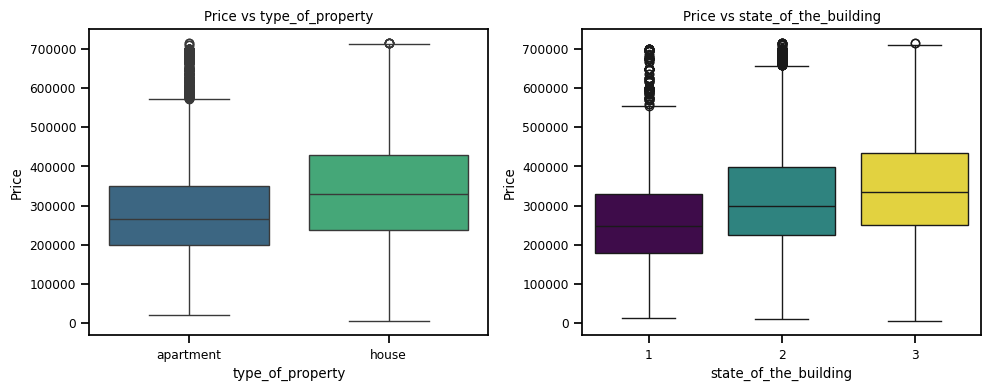

In [844]:
cat_columns = ['type_of_property', 'state_of_the_building']

# Plot discrete_columns
fig, axes = plt.subplots(1, len(cat_columns), figsize=(10, 4))

for i, col in enumerate(cat_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

* Continuous columns

<Figure size 600x400 with 0 Axes>

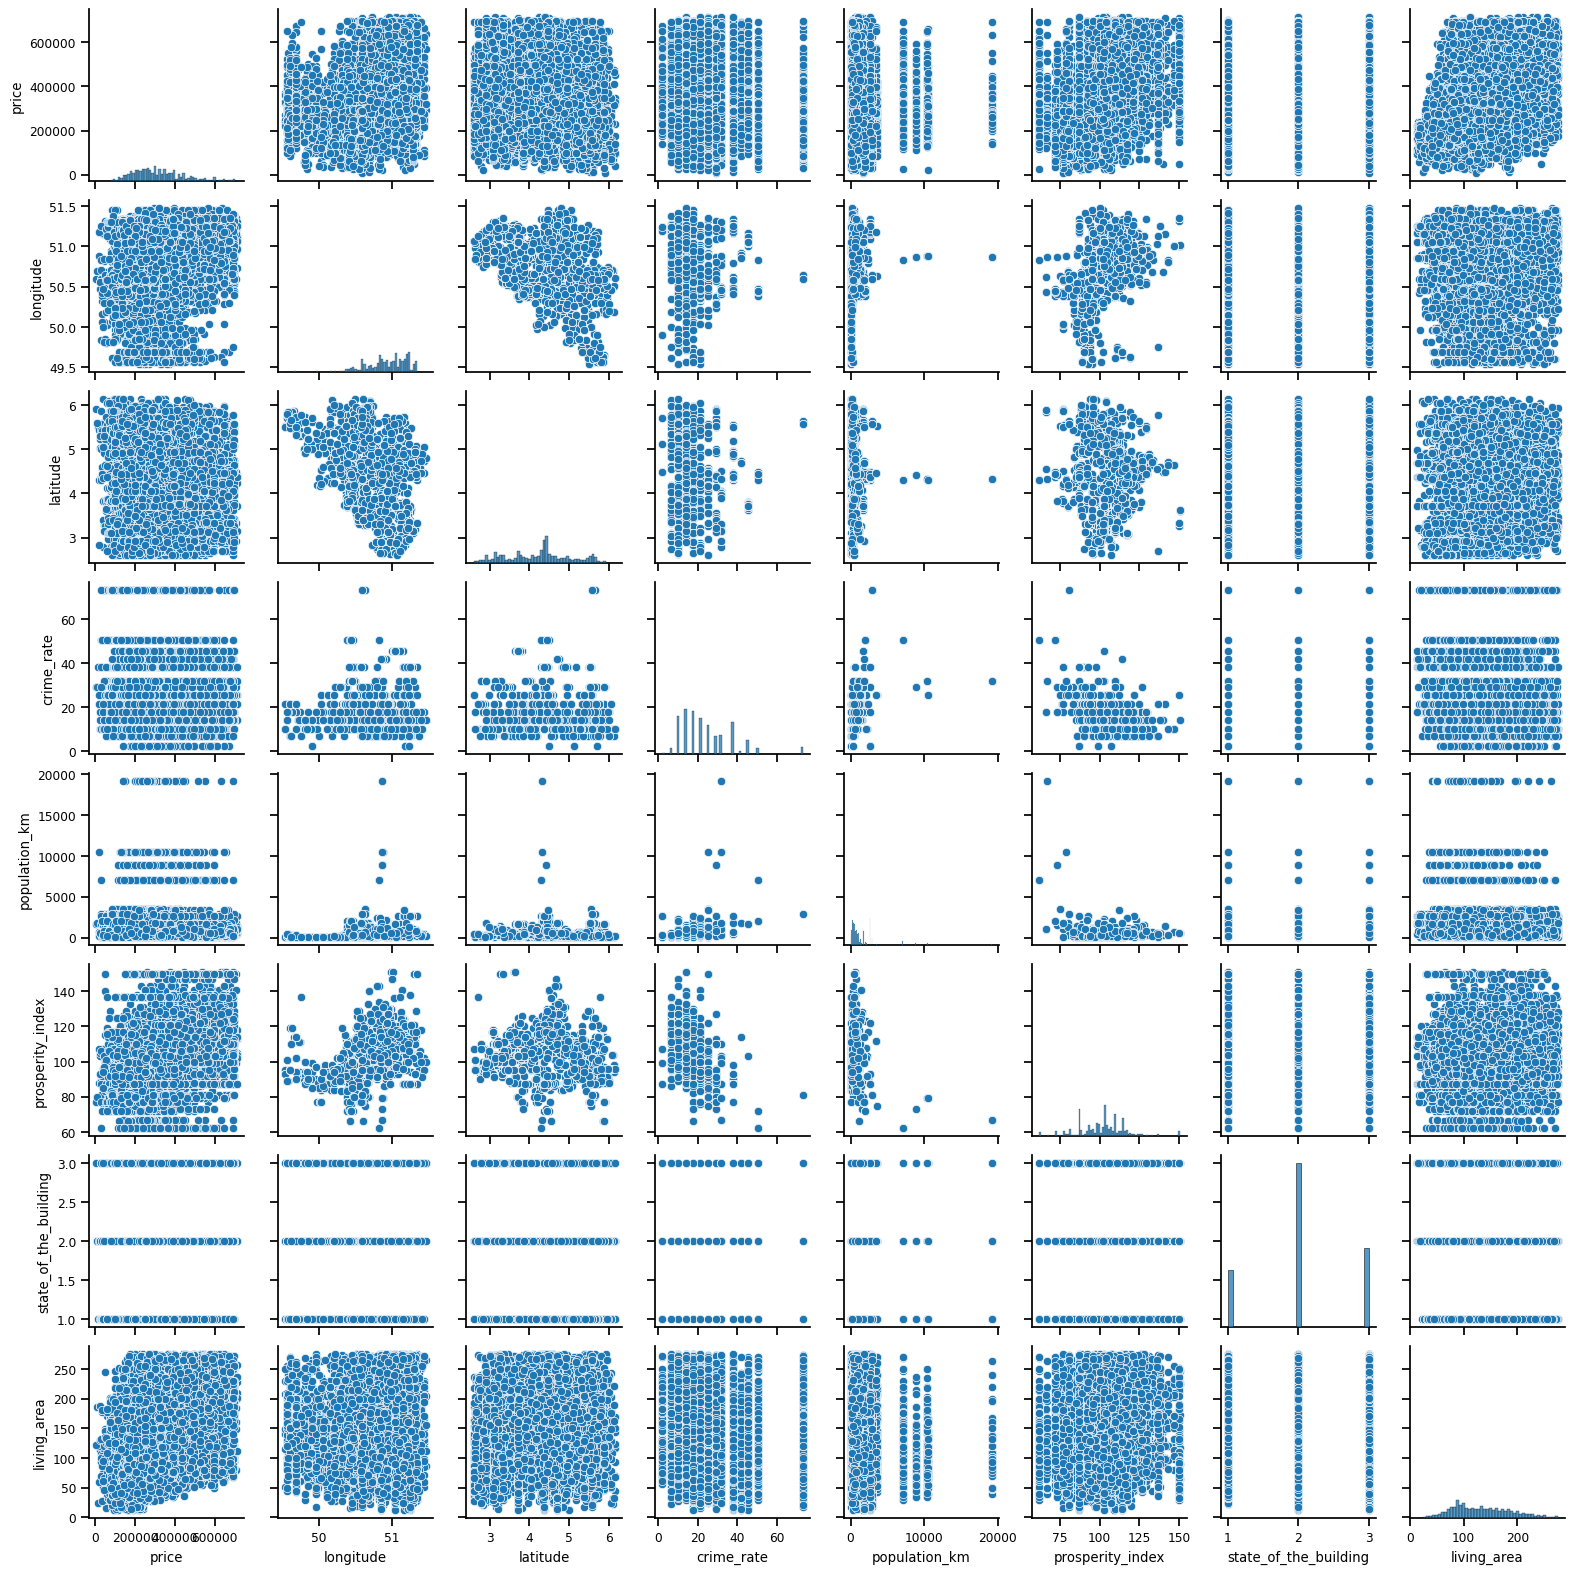

In [845]:
# Plot pairwise relationships for numerical columns
plt.figure(figsize=(6, 4))
sns.set_context('notebook', font_scale=0.8)
sns.pairplot(real_estate_data[continuous_columns], height=2)
plt.show()

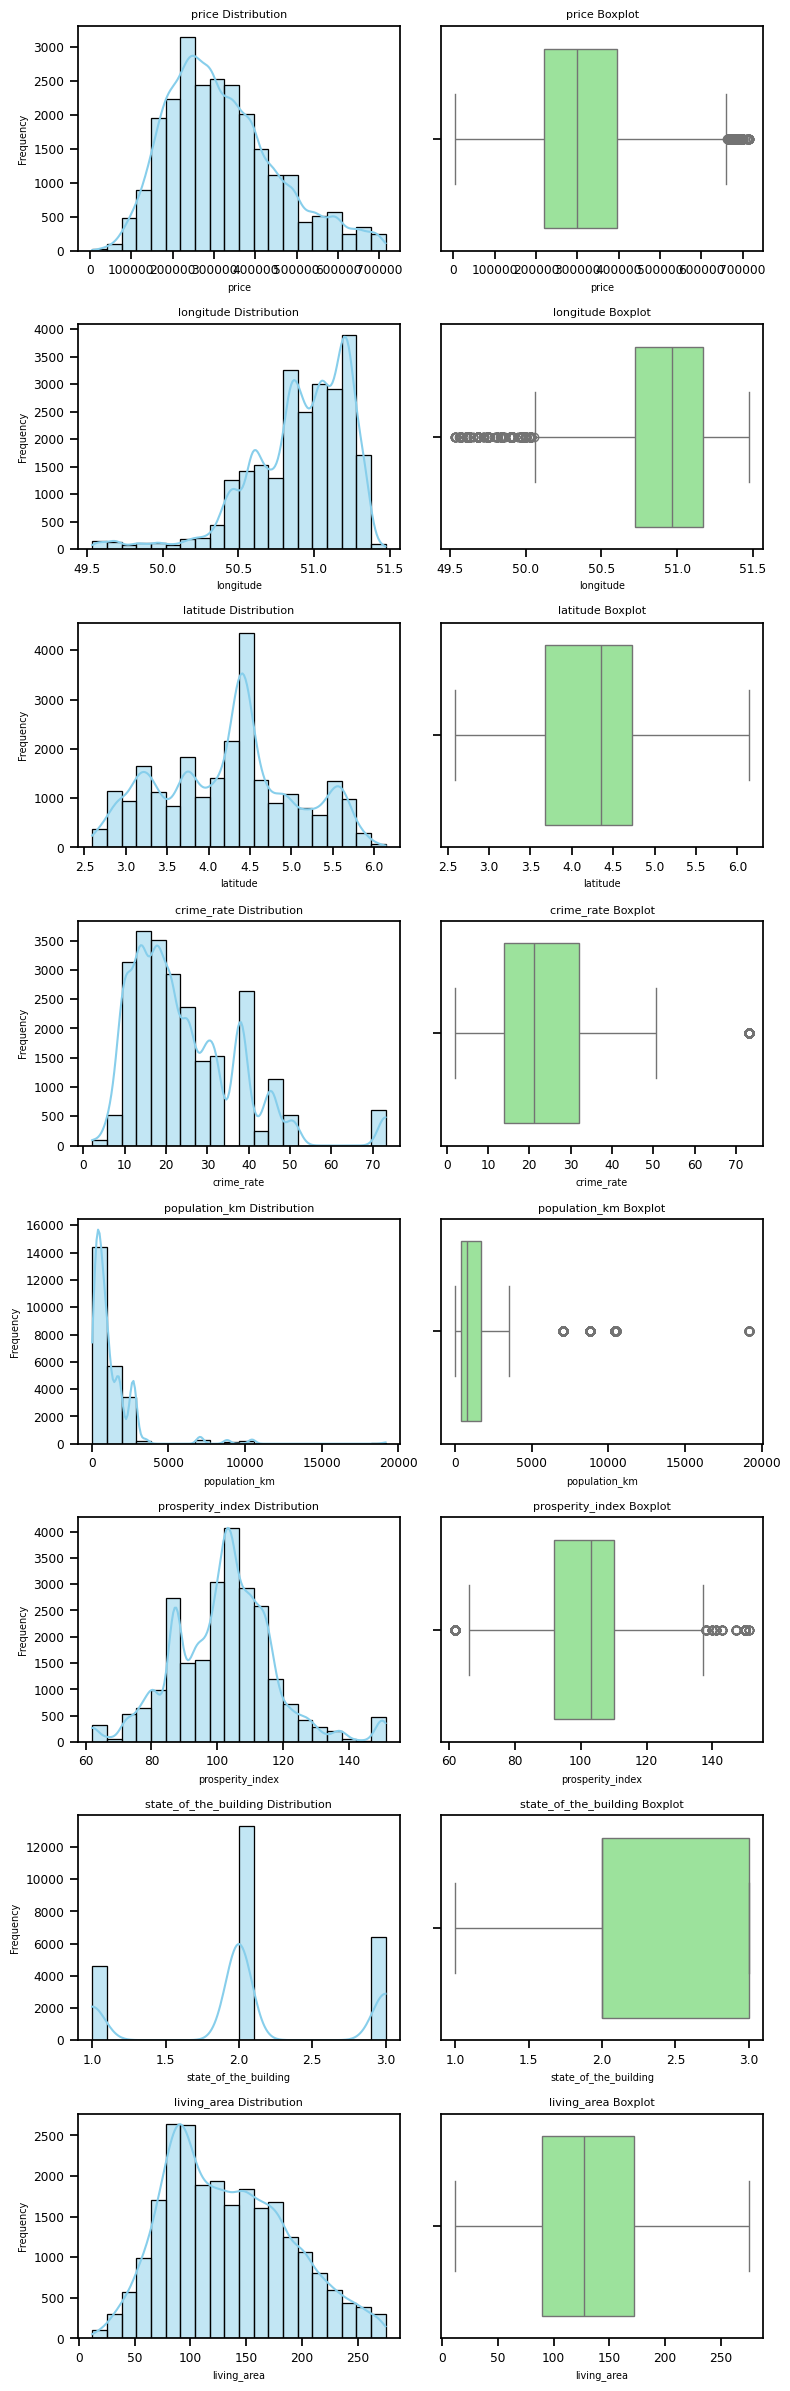

In [846]:
# Plot - histogram and boxplot - for continuous columns
fig, axes = plt.subplots(len(continuous_columns), 2, figsize=(8, len(continuous_columns) * 3))

for i, column in enumerate(continuous_columns):
    # Histogram with KDE
    sns.histplot(real_estate_data[column], kde=True, ax=axes[i, 0], color='skyblue', bins=20)
    axes[i, 0].set_title(f'{column} Distribution', fontsize=8)
    axes[i, 0].set_xlabel(column, fontsize=7)
    axes[i, 0].set_ylabel('Frequency', fontsize=7)

    # Boxplot
    sns.boxplot(data=real_estate_data, x=column, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{column} Boxplot', fontsize=8)
    axes[i, 1].set_xlabel(column, fontsize=7)

plt.tight_layout()
plt.show()

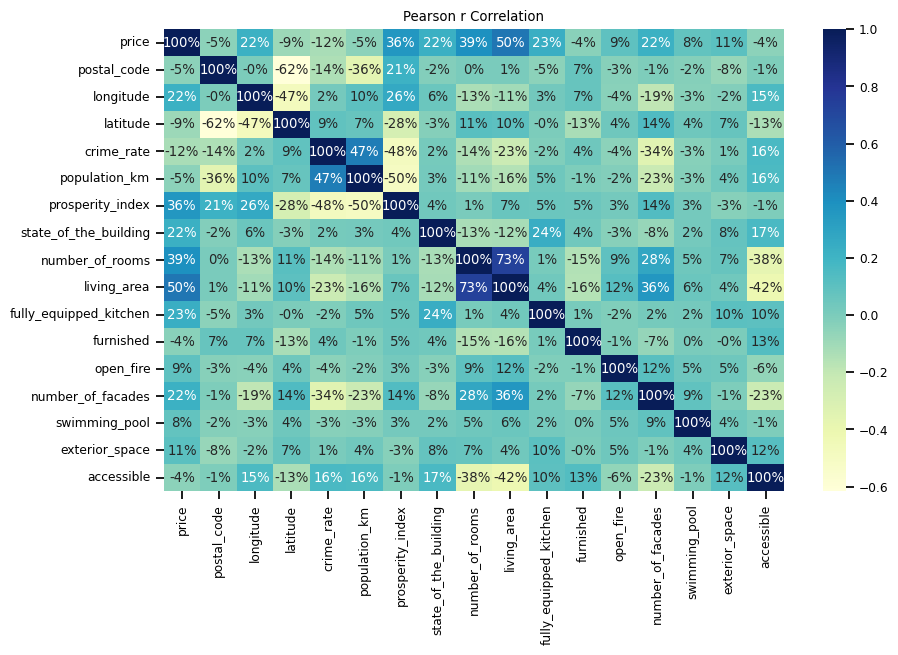

In [847]:
categorical_features = real_estate_data.select_dtypes(include = ["object"]).columns
numerical_features = real_estate_data.select_dtypes(exclude=["object"]).columns

pearson_corr_matrix = real_estate_data[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="YlGnBu",fmt = '.0%')
plt.title("Pearson r Correlation")
plt.show()

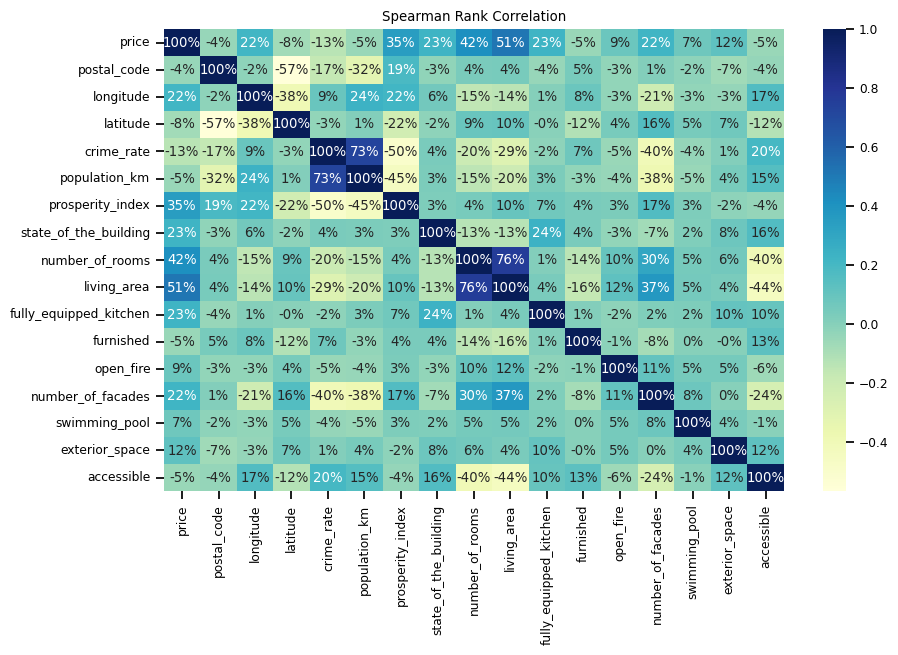

In [848]:
plt.figure(figsize=(10,6))
sns.heatmap(real_estate_data[numerical_features].corr(method='spearman'), annot=True, cmap="YlGnBu",fmt = '.0%')
plt.title("Spearman Rank Correlation")
plt.show()

In [849]:
# Calculate the correlation matrix for continuous columns
correlation_df = pd.DataFrame(real_estate_data[numerical_features].corr().round(2))
correlation_df


,price,postal_code,longitude,latitude,crime_rate,population_km,prosperity_index,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,exterior_space,accessible
price,1.00,-0.05,0.22,-0.09,-0.12,-0.05,0.36,0.22,0.39,0.50,0.23,-0.04,0.09,0.22,0.08,0.11,-0.04
postal_code,-0.05,1.00,-0.00,-0.62,-0.14,-0.36,0.21,-0.02,0.00,0.01,-0.05,0.07,-0.03,-0.01,-0.02,-0.08,-0.01
longitude,0.22,-0.00,1.00,-0.47,0.02,0.10,0.26,0.06,-0.13,-0.11,0.03,0.07,-0.04,-0.19,-0.03,-0.02,0.15
latitude,-0.09,-0.62,-0.47,1.00,0.09,0.07,-0.28,-0.03,0.11,0.10,-0.00,-0.13,0.04,0.14,0.04,0.07,-0.13
crime_rate,-0.12,-0.14,0.02,0.09,1.00,0.47,-0.48,0.02,-0.14,-0.23,-0.02,0.04,-0.04,-0.34,-0.03,0.01,0.16
population_km,-0.05,-0.36,0.10,0.07,0.47,1.00,-0.50,0.03,-0.11,-0.16,0.05,-0.01,-0.02,-0.23,-0.03,0.04,0.16
prosperity_index,0.36,0.21,0.26,-0.28,-0.48,-0.50,1.00,0.04,0.01,0.07,0.05,0.05,0.03,0.14,0.03,-0.03,-0.01
state_of_the_building,0.22,-0.02,0.06,-0.03,0.02,0.03,0.04,1.00,-0.13,-0.12,0.24,0.04,-0.03,-0.08,0.02,0.08,0.17
number_of_rooms,0.39,0.00,-0.13,0.11,-0.14,-0.11,0.01,-0.13,1.00,0.73,0.01,-0.15,0.09,0.28,0.05,0.07,-0.38
living_area,0.50,0.01,-0.11,0.10,-0.23,-0.16,0.07,-0.12,0.73,1.00,0.04,-0.16,0.12,0.36,0.06,0.04,-0.42


Price is positively influenced by living_area, prosperity_index, number_of_rooms and it shows little to no correlation with population_km, postal_code, furnished, open_fire and accessible.

In [850]:
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = real_estate_data[numerical_features].columns
vif["VIF"] = [variance_inflation_factor(real_estate_data[numerical_features].values, i) for i in range(real_estate_data[numerical_features].shape[1])]

vif

,Feature,VIF
0,price,14.480447
1,postal_code,8.904795
2,longitude,266.824027
3,latitude,54.644629
4,crime_rate,7.027777
5,population_km,2.953125
6,prosperity_index,96.896265
7,state_of_the_building,12.819928
8,number_of_rooms,16.093244
9,living_area,20.383503


The columns longitude, latitude, prosperity_index have high VIF values, multicollinearity among these features. 

In decision trees, multicollinearity is handled implicitly through the feature selection process.

In [851]:
real_estate_data = real_estate_data.drop_duplicates()
real_estate_data.shape

(23963, 21)

In [852]:
real_estate_data.head(10)

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,exterior_space,accessible
2,289000.0,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,10.055527,223.812277,98.0,...,3,3.0,120.0,0,0.0,0,1.0,0.0,1,1
5,259000.0,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.729898,274.633658,110.0,...,2,3.0,154.0,0,0.0,0,4.0,0.0,1,0
8,429210.0,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,2,2.0,100.0,1,0.0,0,3.0,0.0,1,1
9,314000.0,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,25.270628,1377.249099,103.0,...,3,2.0,96.0,1,0.0,0,4.0,0.0,1,1
10,229000.0,2500,51.131602,4.561792,région flamande,antwerpen,lier,21.221750,766.455003,109.0,...,2,2.0,105.0,0,0.0,0,2.0,0.0,0,0
12,359000.0,9300,50.941781,4.047008,région flamande,flandre orientale (la),aalst,17.729898,1156.875981,105.0,...,3,3.0,122.0,0,0.0,0,2.0,0.0,1,0
13,260000.0,9620,50.868935,3.790569,région flamande,flandre orientale (la),zottegem,17.729898,488.761973,116.0,...,2,3.0,219.0,0,0.0,0,3.0,0.0,0,0
14,375000.0,1440,50.678788,4.268278,région wallonne,brabant wallon (le),braine-le-château,13.889408,467.972994,116.0,...,3,2.0,124.0,0,0.0,0,2.0,0.0,1,1
15,340000.0,2150,51.191459,4.487687,région flamande,antwerpen,borsbeek,2.119141,2666.254939,87.0,...,1,4.0,270.0,0,0.0,0,2.0,0.0,0,0
16,345000.0,8200,51.193722,3.170873,région flamande,flandre occidentale (la),brugge,29.267071,850.208400,110.0,...,2,2.0,81.0,0,0.0,0,2.0,0.0,0,0


***

In [853]:
real_estate_data.columns

Index(['price', 'postal_code', 'longitude', 'latitude', 'region', 'province',
       'municipality', 'crime_rate', 'population_km', 'prosperity_index',
       'type_of_property', 'state_of_the_building', 'number_of_rooms',
       'living_area', 'fully_equipped_kitchen', 'furnished', 'open_fire',
       'number_of_facades', 'swimming_pool', 'exterior_space', 'accessible'],
      dtype='object')

### Save dataframe

In [854]:
real_estate_data.to_csv('data/real_estate_belguim.csv', index=False)